# Graph to analyze the commenters under a Youtuber's videos

In [25]:
import polars as pl
from plotnine import ggplot, geom_point, geom_col, geom_line, aes, scale_color_identity, labs, theme, element_text, scale_x_datetime, scale_x_discrete, theme_minimal, facet_wrap, guides, geom_smooth, coord_flip, geom_text, scale_x_continuous, geom_segment
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import numpy as np
# https://manual.cytoscape.org/

#### filter

In [26]:
video_id = "ektIcnUglIw"

In [27]:
topic = "19" # the filter can be a subject too

#### The youtuber to be analyzed

In [28]:
video_file = "./corpus/tatiana_ventose_videos.csv"
first_comment_file = "./corpus/tatiana_ventose_comments_first-comments.csv"
replies_file = "./corpus/tatiana_ventose_comments-replies.csv"
commenter_file = "./corpus/tatiana_ventose_commenters.csv"
ytb = "tatiana_ventose"
ytb_name = "Tatiana Ventôse"

In [29]:
videos = pl.read_csv(video_file).with_columns(
    pl.col('published_at').str.to_datetime(),
    pl.col('duration').str.replace_all("^PT([0-9]{1,2})S$", "00:00:$1").str.replace_all("^PT([0-9]{1,2})M([0-9]{1,2})S$", "00:$1:$2").str.replace_all("^PT([0-9]{1,2})H([0-9]{1,2})M([0-9]{1,2})S$", "$1:$2:$3").str.replace_all("^PT([0-9]{1,2})M$", "00:$1:00").str.to_time("%H:%M:%S"),
    pl.col("tags").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("topics").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("gensim_topics").str.split(by="|"),
    pl.col("comment_count").fill_null(-1),
    pl.col("view_count").fill_null(-1),
    pl.col("like_count").fill_null(-1)
).filter(pl.col("video_id") == video_id)

In [30]:
first_comments = pl.read_csv(first_comment_file).filter(pl.col("position") == 1)
replies = pl.read_csv(replies_file).filter(pl.col("position") > 1)
comments = pl.concat([first_comments, replies], how="vertical").with_columns(
    pl.col('published_at').str.slice(0, length=4).alias("year"),
    pl.col('updated_at').str.to_datetime(), 
    pl.col('published_at').str.to_datetime(),
    pl.col("like_count").fill_null(0),
    pl.col("reply_count").fill_null(0)
).filter(pl.col("video_id") == video_id)

In [31]:
commenters_id = comments["author_channel_id"].to_list()
commenters = pl.read_csv(commenter_file).with_columns(
        pl.col('published_at').str.to_datetime(),
    pl.col("description").str.replace_all("^$", "Not_provided"),
    pl.col("topics").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("keywords").fill_null("Not_provided").str.split(by="|"),
).filter(
    pl.col("channel_id").is_in(commenters_id)
)

## Annotation of discussions based on the agreement of the first comment

In [32]:
first_comments = comments.filter(
    pl.col("position") == 1
).with_columns(
    pl.when(pl.col("accord") > 0.75)
    .then(1)
    .when(pl.col("desaccord") > 0.75)
    .then(-1)
    .when(pl.col("ambigue") > 0.75)
    .then(0)
    .otherwise(0)
    .alias("fc_label")
).select(
    ["first_comment_id", "fc_label"]
)

In [33]:
# on uniformise l'annotation des commentaires en même temps
comments = comments.join(
    first_comments, on="first_comment_id", how="left"
).with_columns(
    pl.when(pl.col("accord") > 0.75)
    .then(1)
    .when(pl.col("desaccord") > 0.75)
    .then(-1)
    .when(pl.col("ambigue") > 0.75)
    .then(0)
    .otherwise(0)
    .alias("label")
).select(
    ["first_comment_id", "comment_id", "author_name", "author_channel_id", "text", "like_count", "position", "toxicity", "fc_label", "label"]
)

## Annotation of discussions based on the agreement in the discussion

In [34]:
comments = comments.join(
    comments.group_by("first_comment_id").agg(pl.col("label").mean().alias("discussion_label")), on="first_comment_id"
)

## Annotation of commenters based on the agreement of their comments

In [35]:
comments = comments.join(
    comments.group_by("author_channel_id").agg(pl.col("label").mean().alias("channel_label")), on="author_channel_id", how="left"
)

## Add the name of the first commenters in all line

In [36]:
comments = comments.join(
    comments.filter(pl.col("position") == 1).rename({"author_name": "first_author_name", "author_channel_id": "first_author_channel_id"}).select(["first_comment_id", "first_author_name", "first_author_channel_id"]),
    on = "first_comment_id",
    how="left"
).sort(["first_comment_id", "position"])

## save new file

In [37]:
comments.write_csv(f"new_{ytb}.csv")

## Stats

In [38]:
# number of comments
comments.height

1182

In [39]:
# number of commenters
comments.group_by("author_channel_id").agg("label").height

562

In [40]:
# number of comments by commenters
comments.group_by("author_channel_id").agg(pl.col("label").len().alias("comments_count")).sort("comments_count", descending=True)

author_channel_id,comments_count
str,u32
"""UCXo7-knlDe0na06tHX58uXQ""",23
"""UCOO6LzQXWqIeLIcbDDp-v9A""",21
"""UCPNBWG773rvVkSMk5oSRSJQ""",20
"""UCg9Gq7UR3YpoLeKTFs94mYQ""",16
"""UCUmrmGqK_9PkD71B3UxFRmQ""",16
…,…
"""UCQXaKgHSBGf5jJH8qe8Rh-w""",1
"""UCMoX-U1ufeIKGyfq1Xu23dQ""",1
"""UCkPEOfgrUZ4GVZcMQOYrdyg""",1


In [41]:
# number of commenters with more than 1 comment
comments.group_by("author_channel_id").agg(pl.col("label").len().alias("comments_count")).filter(pl.col("comments_count") > 1).height

215

In [42]:
# number of commenters with 1 comment
comments.group_by("author_channel_id").agg(pl.col("label").len().alias("comments_count")).filter(pl.col("comments_count") == 1).height

347

In [43]:
# fc accord
comments.filter((pl.col("fc_label") == 1) & (pl.col("position") == 1)).height

64

In [44]:
# fc désaccord
comments.filter((pl.col("fc_label") == -1) & (pl.col("position") == 1)).height

75

In [45]:
# fc ambigue
comments.filter((pl.col("fc_label") == 0) & (pl.col("position") == 1)).height

85

## toxicity in discussion based on first comment agreement and discussion agreement

In [48]:
len_position = comments.group_by(
    "first_comment_id"
).agg(
    "position"
).with_columns(
    pl.col("position").list.len().alias("len_position")
).select(["first_comment_id", "len_position"])

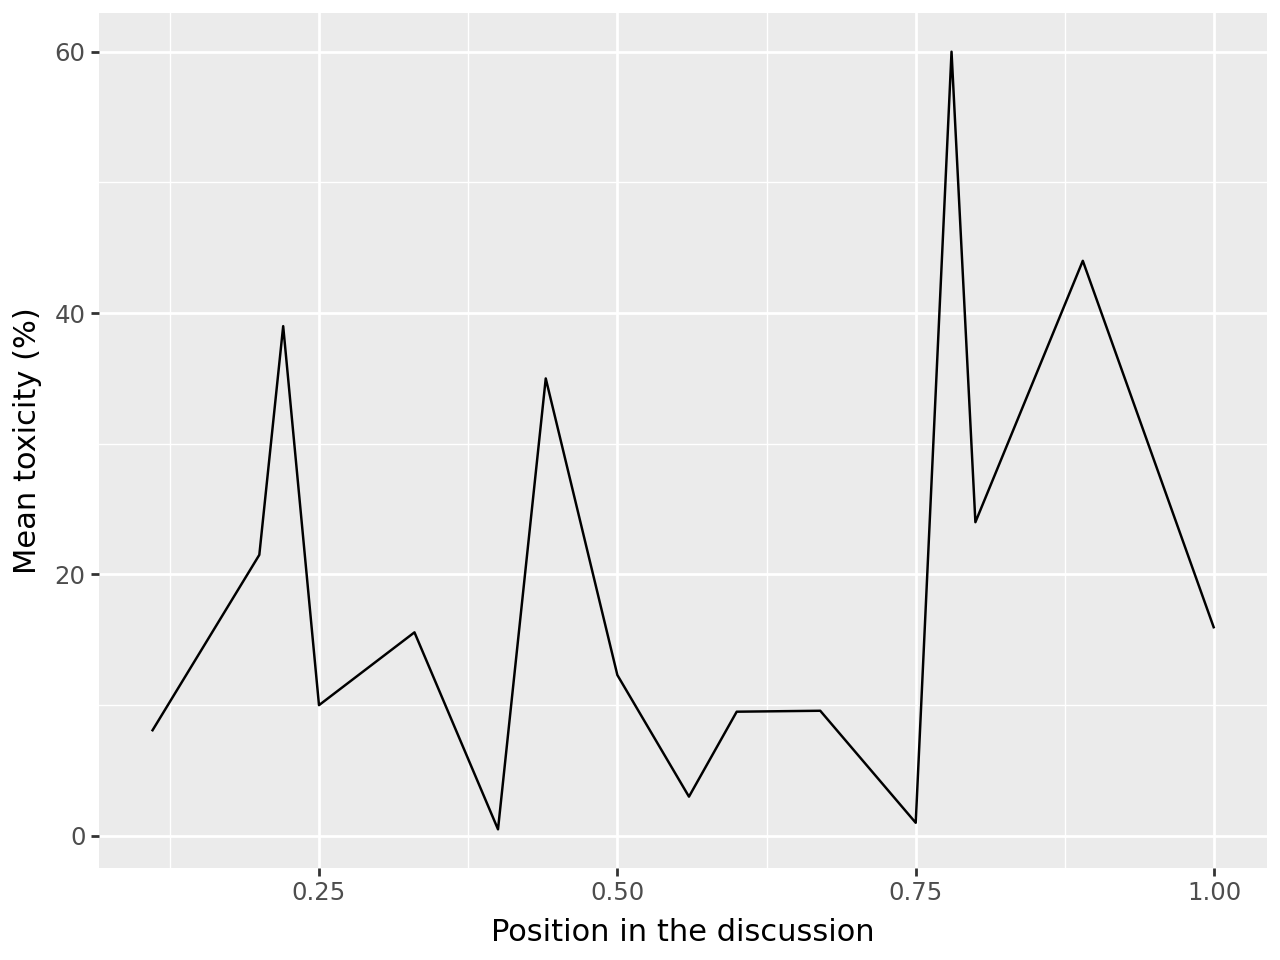

In [59]:
# commence par accord
df = comments.join(
    len_position, on="first_comment_id"
).filter(
    (pl.col("fc_label") == 1) & (pl.col("discussion_label") >= 0.33)
).with_columns(
    (pl.col("position") / pl.col("len_position")).round(2).alias("position"),
    (pl.col("toxicity") * 100).round()
).group_by(
    pl.col("position")
).agg(
    pl.col("toxicity").mean()
).sort("position")

p = (
    ggplot(df, aes("position", "toxicity"))
    + geom_line()
    # + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + labs(x="Position in the discussion", y="Mean toxicity (%)")
)
p.show()

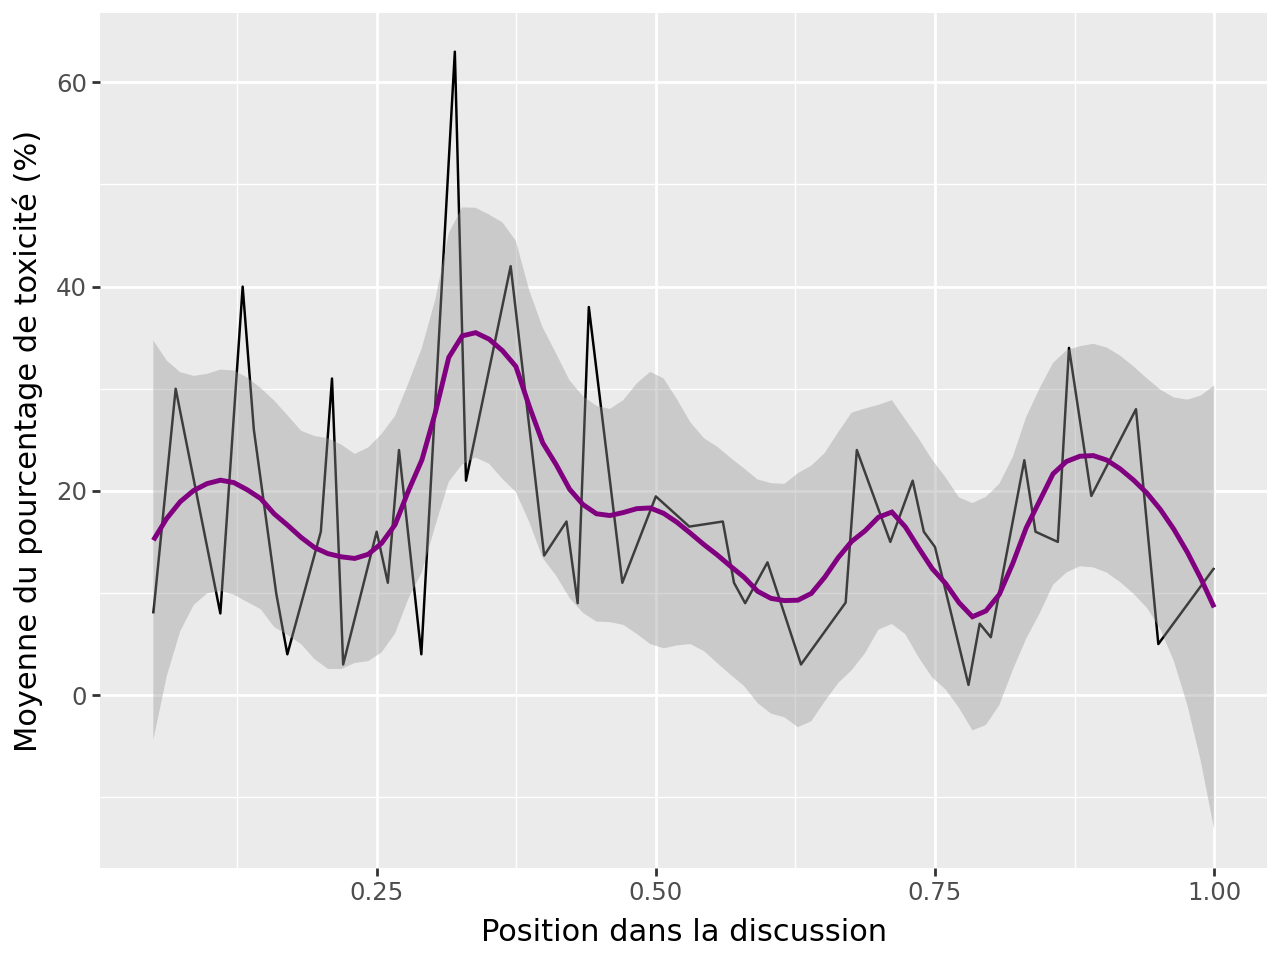

In [60]:
# commence par ambigue
df = comments.join(
    len_position, on="first_comment_id"
).filter(
    (pl.col("fc_label") == -1) & (pl.col("discussion_label") <= -0.33)
).with_columns(
    (pl.col("position") / pl.col("len_position")).round(2).alias("position"),
    (pl.col("toxicity") * 100).round()
).group_by(
    pl.col("position")
).agg(
    pl.col("toxicity").mean()
).sort("position")

p = (
    ggplot(df, aes("position", "toxicity"))
    + geom_line()
    + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + labs(x="Position dans la discussion", y="Moyenne du pourcentage de toxicité (%)")
)
p.show()

## grah : commenters common in pair of discussion 

In [61]:
# node_table
comments.select(
    ["first_comment_id", "discussion_label", "label"]
).join(
    comments.group_by("first_comment_id").agg(pl.col("author_channel_id").unique().len().alias("size")),
    on="first_comment_id",
    how="left"
).rename(
    {"first_comment_id": "name", "discussion_label": "degree"}
).with_columns(
    pl.col("degree").round(2)
).write_csv("./discussion_nodes.csv")
# degree = agreement in the discussion (between -1 and 1)
# label = label of the first comment (1, 0 or -1)
# size = number of comments in the discussion (2 to n)

In [62]:
# apply all discussions to search for common commenters
# filter discussion with less than 2 commenters
# select common commenters in each pair of discussion
# filter pair of discussion with no commenters and when both discussion have the same id
# verify that there is no double
comments.group_by(
    "first_comment_id"
).agg(
    pl.col("author_channel_id")
).filter(
    pl.col("author_channel_id").list.unique().list.len() > 2
).with_columns(
    discussion=pl.lit(comments["first_comment_id"].unique().to_list())
).explode(
    "discussion"
).join(
    comments.group_by("first_comment_id").agg(pl.col("author_channel_id").unique()), 
    left_on="discussion",
    right_on="first_comment_id",
    how="left"
).with_columns(
    interaction=pl.col("author_channel_id").list.set_intersection("author_channel_id_right")
).rename(
    {"first_comment_id": "source", "discussion": "target"}
).select(
    ["source", "interaction", "target"]
).with_columns(
    pl.when(pl.col("source") > pl.col("target"))
    .then(pl.col("target"))
    .otherwise(pl.col("source"))
    .alias("source"),
    pl.when(pl.col("source") > pl.col("target"))
    .then(pl.col("source"))
    .otherwise(pl.col("target"))
    .alias("target")
).explode(
    "interaction"
).filter(
    (pl.col("interaction").is_not_null()) & (pl.col("source") != pl.col("target"))
).unique().write_csv("discussion_edges.csv")

## grah : commenters common in pair of discussion based on agreement

for exemple, to observe if commenters in high agreement discussion go to other discussion to attack people "outside of the echo chamber"

In [25]:
# node_table
comments.filter(
    pl.col("position") == 1
).select(
    ["first_comment_id", "discussion_label", "label"]
).join(
    comments.group_by("first_comment_id").agg(pl.col("author_channel_id").unique().len().alias("size")),
    on="first_comment_id",
    how="left"
).rename(
    {"first_comment_id": "name", "discussion_label": "degree"}
).with_columns(
    pl.col("degree").round(2)
).write_csv("./discussion_nodes.csv")

In [26]:
# select high agreement discussion that start with agree 
# apply all discussions to search for common commenters
# filter discussion with less than 2 commenters
# select common commenters in each pair of discussion
# filter pair of discussion with no commenters and when both discussion have the same id
# verify that there is no double
comments.filter(
    (pl.col("fc_label") == 1) & (pl.col("discussion_label") >= 0.33)
).group_by(
    "first_comment_id"
).agg(
    pl.col("author_channel_id")
).filter(
    pl.col("author_channel_id").list.unique().list.len() > 2
).with_columns(
    discussion=pl.lit(comments["first_comment_id"].unique().to_list())
).explode(
    "discussion"
).join(
    comments.group_by("first_comment_id").agg(pl.col("author_channel_id").unique()), 
    left_on="discussion",
    right_on="first_comment_id",
    how="left"
).with_columns(
    interaction=pl.col("author_channel_id").list.set_intersection("author_channel_id_right")
).rename(
    {"first_comment_id": "source", "discussion": "target"}
).select(
    ["source", "interaction", "target"]
).with_columns(
    pl.when(pl.col("source") > pl.col("target"))
    .then(pl.col("target"))
    .otherwise(pl.col("source"))
    .alias("source"),
    pl.when(pl.col("source") > pl.col("target"))
    .then(pl.col("source"))
    .otherwise(pl.col("target"))
    .alias("target")
).explode(
    "interaction"
).filter(
    (pl.col("interaction").is_not_null()) & (pl.col("source") != pl.col("target"))
).unique().write_csv("discussion_edges.csv")